# Inleveropgave 2: Model-Free Prediction and Control

### Imports

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

## Voorbereiding
Kopiëren van base class vanuit vorige opdracht aangevuld met een policy visualization method.

In [2]:
class Maze():
    def __init__(self, rewards: np.array, exit_positions: list, chance: float):
        """ Initialize maze
        :param rewards: 2D array of rewards
        :param exit_positions: list of exit positions
        :param chance: chance of moving to the chosen state
        """
        self.rewards = rewards
        # Use exploring starts
        self.exit_positions = exit_positions
        self.start_pos = self.get_random_position()
        self.chance = chance

        # bind moves to constant
        self.actions = {
            "UP": (-1, 0),
            "DOWN": (1, 0),
            "LEFT": (0, -1),
            "RIGHT": (0, 1),
        }
        self.list_actions = list(self.actions.keys())

    def get_random_position(self):
        """ Retrieve random position from grid exlcuding exit positions
        :return: random position in grid
        """
        while True:
            x = np.random.randint(0, self.rewards.shape[0])
            y = np.random.randint(0, self.rewards.shape[1])
            if (x, y) not in self.exit_positions:
                return (x, y)


    def reset(self):
        """ Reset the environment to a random start state """
        self.start_pos = self.get_random_position()

    def get_action_with_probabilities(self, desired_action: str):
        """ Take probabilities into account while choosing action	
        :param desired_action: chosen action
        :return: action with probabilities taken into account
        """

        other_actions = list(set(self.list_actions)- {desired_action})
        chance_left = 1 - self.chance
        chance_per_action = round(chance_left / len(other_actions), 1)
        other_probabilities = [chance_per_action for _ in range(0, len(other_actions))]

        return np.random.choice(
            [desired_action, *other_actions],
            replace=False,
            p=[self.chance, *other_probabilities]
        )
    
    def get_next_position(self, location: tuple, action: str):
        """ Get next position giving a certain action
        :param location: current position
        :param action: chosen action
        """
        actual_action = self.get_action_with_probabilities(action)
        x_dim, y_dim = self.rewards.shape
        y, x = location
        next_y, next_x = self.actions[actual_action]
        next_x += x
        next_y += y

        # Check if position is inside grid, else stay in same place
        if (next_x >= 0 and next_x < x_dim and next_y >= 0 and next_y < y_dim):
            return (next_y, next_x)

        return location
    
    def value_iteration(self, theta: float = 0.001):
        """ Value iteration algorithm
        :param theta: threshold for convergence
        :return: optimal policy
        """
        n_actions = len(self.list_actions)
        V = np.zeros(self.rewards.shape)
        while True:
            delta = 0
            for y in range(self.rewards.shape[0]):
                for x in range(self.rewards.shape[1]):  
                    location = (y, x)
                    if location in self.exit_positions:
                        continue

                    # Find best action
                    A = self.lookahead_step(location, V)
                    max_val = np.max(A)
                    delta = max(delta, np.abs(max_val - V[location]))
                    # Update value function
                    V[location] = max_val
            if delta < theta:
                break

        V = np.add(V, self.rewards)

        # Generate policy by using optimal value function
        policy = np.zeros([self.rewards.shape[0], self.rewards.shape[1], n_actions])
        for y in range(self.rewards.shape[0]):
            for x in range(self.rewards.shape[1]):
                location = (y, x)

                A = self.lookahead_step(location, V)
                best_action = np.argmax(A)
                policy[y, x, best_action] = 1.0

        return policy, V

    def lookahead_step(self, location: tuple, V: np.array, discount_factor: float = 1.0):
        """ Find most optimal step
        :param location: current position
        :param V: value function
        :param discount_factor: discount factor
        """
        n_actions = len(self.list_actions)
        A = np.zeros(n_actions)
        a_idx = 0
        for action in self.list_actions:
            next_state = self.get_next_position(location, action)
            if next_state == location:
                continue
            A[a_idx] = self.chance * (self.rewards[next_state] + discount_factor * V[next_state])
            a_idx += 1
        return A
    
    def generate_random_policy(self):
        """ Generate random policy
        :return: random policy
        """
        n_actions = len(self.list_actions)
        # Generate policy by taking random actions from action list
        policy = np.zeros([self.rewards.shape[0], self.rewards.shape[1], n_actions])
        for y in range(self.rewards.shape[0]):
            for x in range(self.rewards.shape[1]):
                best_action = np.random.randint(0, n_actions)
                policy[y, x, best_action] = 1.0

        return policy
    
    def run(self, policy):
        """ Run the policy on the environment
        :param policy: policy to run
        :return: states visited, actions taken, rewards received
        """
        location = self.start_pos
        states = [location]
        actions = []
        rewards = [0]
        while True:
            action_idx = np.argmax(policy[location])
            action = self.list_actions[action_idx]
            location, reward, done = self.step(location, action)
            states.append(location)
            actions.append(action)
            rewards.append(reward)
            if done:
                break
        return states, actions, rewards

    def step(self, state, action):
        """ Take action in state
        :param state: current state
        :param action: action to take
        :return: next state, reward, done
        """
        next_state = self.get_next_position(state, action)
        reward = self.rewards[next_state]
        done = next_state in self.exit_positions
        return next_state, reward, done
        
    def visualize_policy(self, policy):
        """ Visualize policy
        :param policy: policy to visualize
        :return: dataframe visualizing policy
        """
        argmaxed_policy = np.argmax(policy, axis=-1)
        visual_policy = np.vectorize(self.list_actions.__getitem__)(argmaxed_policy)

        return pd.DataFrame(data=visual_policy)

    def test_agent(self, Q, n_tests, epsilon = 1):
        """ Test agent for SARSA
        :param Q: Q-table
        :param n_tests: number of tests
        :param epsilon: epsilon for epsilon-greedy
        """
        n_actions = len(self.list_actions)
        for test in range(n_tests):
            print(f"Test #{test} ----------------")
            print(f"Starting at {self.start_pos}")
            s = self.start_pos
            while True:
                a = epsilon_greedy(Q, epsilon, n_actions, s, train=True)
                s, _, done = self.step(s, self.list_actions[a])
                print(f"Chosen action: {self.list_actions[a]} New state: {s}")
                if done:
                    if s != self.start_pos:
                        print(f"Successfully reached exit {s}")
                    else:
                        print("Failed")
                    break
            self.reset()

## 1. Model-Free Prediction
De enige manier om erachter te komen hoe de wereld in elkaar zit voor mensen, is door de wereld te ervaren. We worden ouder, we maken fouten, af en toe doen we iets goed, daar krijgen we dan meestal een beloning voor. Langzaam maar zeker evolueert ons model. Deze vorm van ervaring op doen noemen we "Sampling" in het veld van Reinforcement Learning. Om een value-function te krijgen zonder gegeven model van de wereld kunnen we dit idee toepassen.
### 1.1 Monte-Carlo Policy Evaluation
Implementeer Monte-Carlo Policy evaluation en voer deze uit op de doolhof. Evalueer daarmee twee policies met γ=0.9 en γ=1.

π0, de random policy. Deze doet altijd een random, legale, actie.

π∗, de optimale policy. Deze heb je de vorige opdracht al weten te bepalen met behulp van Value Iteration.

![Monte Carlo Policy Evaluation](images/montecarlopolicyeval.png "Monte Carlo Policy Evaluation")

#### Algorithm

In [3]:
class MazeEvaluate(Maze):
    def evaluate_policy(self, policy, n_episodes, discount_factor=1.0):
        """ Evaluate a policy by using the `run_episode` method.
        :param policy: A policy to be evaluated.
        :param n_episodes: Number of episodes to be used for evaluation.
        :param discount_factor: Gamma discount factor.
        :return: A list containing the cumulative rewards of each episode.
        """
        returns_sum = np.zeros(self.rewards.shape)
        returns_count = np.zeros(self.rewards.shape)

        V = np.zeros(self.rewards.shape)

        for _ in tqdm(range(1, n_episodes + 1)):
            # Generate an episode by running the run method this returns states, actions and rewards.
            episode = self.run(policy)

            G = 0
            states = episode[0]
            rewards = episode[2]
            for idx in range(len(states) - 2, 0, -1):
                curr_state = states[idx]
                G = discount_factor * G + rewards[idx + 1]
                if curr_state not in states[:idx - 1]:
                    returns_sum[curr_state] += G
                    returns_count[curr_state] += 1.0
                    V[curr_state] = returns_sum[curr_state] / returns_count[curr_state]
            self.reset()
        return V

#### Setup environment

In [4]:
exit_positions = [(3, 0), (0, 3), (3, 1)]
rewards = np.array([
    [-1, -1, -1, 40],
    [-1, -1, -10, -10],
    [-1, -1, -1, -1],
    [10, -2, -1, -1],
])
chance = .7
maze = MazeEvaluate(
    rewards,
    exit_positions,
    chance
)

#### Calculate optimal and random policy

In [5]:
optimal_policy, v = maze.value_iteration()
random_policy = maze.generate_random_policy()

#### Evaluate & visualize policies

In [6]:
maze = MazeEvaluate(
    rewards,
    exit_positions,
    chance
)

100%|██████████| 1000/1000 [00:01<00:00, 742.19it/s]


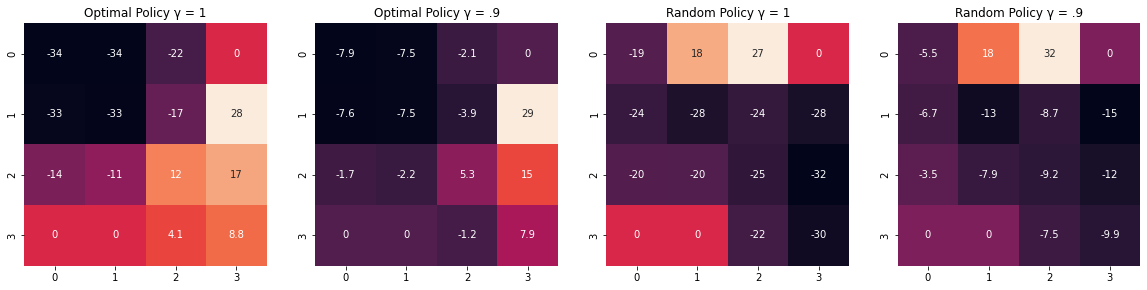

In [7]:
n_episodes = 1000
opt_policy_discount_1 = maze.evaluate_policy(optimal_policy, n_episodes, discount_factor = 1)
opt_policy_discount_09 = maze.evaluate_policy(optimal_policy, n_episodes, discount_factor = .9)
rand_policy_discount_1 = maze.evaluate_policy(random_policy, n_episodes, discount_factor = 1)
rand_policy_discount_09 = maze.evaluate_policy(random_policy, n_episodes, discount_factor = .9)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(20, 10)
sns.heatmap(opt_policy_discount_1, annot=True, square=True, cbar=False, ax=ax1)
sns.heatmap(opt_policy_discount_09, annot=True, square=True, cbar=False, ax=ax2)
# Random Policy
sns.heatmap(rand_policy_discount_1, annot=True, square=True, cbar=False, ax=ax3)
sns.heatmap(rand_policy_discount_09, annot=True, square=True, cbar=False, ax=ax4)

ax1.set_title(r'Optimal Policy γ = 1')
ax2.set_title(r'Optimal Policy γ = .9')
ax3.set_title(r'Random Policy γ = 1')
ax4.set_title(r'Random Policy γ = .9')

plt.show()

## 1.2 Temporal Difference Learning

Een nadeel aan MCPE is dat je mogelijk dood gaat voordat je erachter komt dat je bijna dood ging. Een methode die dit soort problemen kan voorkomen is Temporal Difference Learning. Oftewel TD-learning.
Implementeer TD-Learning. En voer weer met dezelfde twee policies uit met γ=0.9 en γ=1.

![Temporal Difference Learning](images/TD-learning.png "Temporal Difference Learning")

#### Algorithm

In [8]:
class MazeTDLearing(Maze):
    def tabular_td(self, policy, alpha, discount_factor = 1.0):
        """ Temporal Difference Learning algorithm
        :param policy: policy to be learned
        :param alpha: learning rate
        :param discount_factor: discount factor
        """

        V = np.random.random(self.rewards.shape)
        for exit_pos in self.exit_positions:
            V[exit_pos] = 0

        for _ in tqdm(range(n_episodes)):
            # Pick an action
            location = self.start_pos
            while True:
                action = np.argmax(policy[location])
                next_location, reward, done = self.step(location, self.list_actions[action])
                V[location] += alpha * (reward + discount_factor * V[next_location] - V[location])  
                location = next_location
                if done:
                    break
        self.reset()
        return V

#### Evaluate & visualize policies

In [9]:
td_maze = MazeTDLearing(
    rewards,
    exit_positions,
    chance
)

100%|██████████| 1000/1000 [00:01<00:00, 898.40it/s]


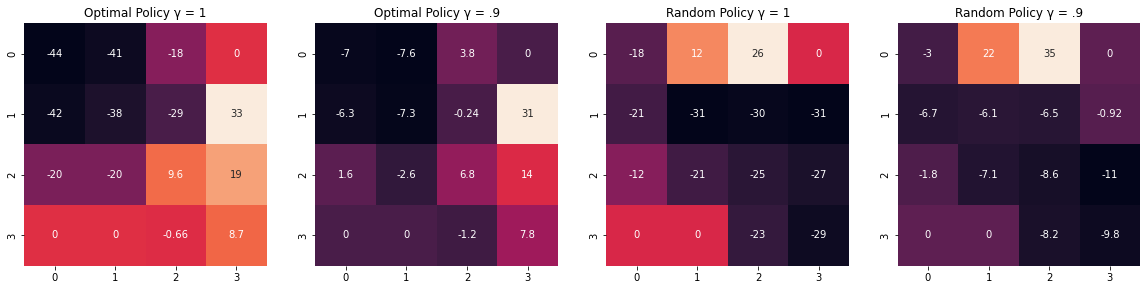

In [10]:
opt_policy_discount_1 = td_maze.tabular_td(optimal_policy, .1, discount_factor = 1)
opt_policy_discount_09 = td_maze.tabular_td(optimal_policy, .1, discount_factor = .9)
rand_policy_discount_1 = td_maze.tabular_td(random_policy, .1, discount_factor = 1)
rand_policy_discount_09 = td_maze.tabular_td(random_policy, .1, discount_factor = .9)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(20, 10)

# Optimal Policy
sns.heatmap(opt_policy_discount_1, annot=True, square=True, cbar=False, ax=ax1)
sns.heatmap(opt_policy_discount_09, annot=True, square=True, cbar=False, ax=ax2)

# Random Policy
sns.heatmap(rand_policy_discount_1, annot=True, square=True, cbar=False, ax=ax3)
sns.heatmap(rand_policy_discount_09, annot=True, square=True, cbar=False, ax=ax4)

ax1.set_title(r'Optimal Policy γ = 1')
ax2.set_title(r'Optimal Policy γ = .9')
ax3.set_title(r'Random Policy γ = 1')
ax4.set_title(r'Random Policy γ = .9')

plt.show()

## 2 Model-Free Control

Nu gaan we toe werken naar de laatste stap. Model-Free control. Daarvoor zijn echter twee problemen die we nog niet hebben opgelost. Onze policy evaluation algoritmes baseren de value-function met behulp van wetenschap wat de volgende state S' is gegeven dat we actie a kiezen in huidige state S. Maar deze kennis hebben we helemaal niet! In plaats daarvan kunnen we beter met q-waardes gaan werken. De Q-waarde is een mapping van states en actions naar utility.


Het grootste verschil is dat we niet hoeven te weten wat de volgende state is. In plaats daarvan slaan we ergens op wat het de resultaten tot dusver waren toen we in state s, actie a namen en wat daarvan de waarde was.

Dan rest ons nog één probleem. Namelijk dat we niet policy iteration of value iteration kunnen toepassen met behulp van een greedy algoritme. Dit leidt namelijk tot sub-optima. In plaats daarvan gebruiken we ε-greedy. ε is een kleine waarde die representatief is voor de kans dat we exploreren, in plaats van exploiteren.

In [11]:
#Source: https://towardsdatascience.com/reinforcement-learning-temporal-difference-sarsa-q-learning-expected-sarsa-on-python-9fecfda7467e
def epsilon_greedy(Q, epsilon, n_actions, s, train=False):
    """
    :param Q: Q values state x action -> value
    :param epsilon: for exploration
    :param s: number of states
    :param train: if true then no random actions selected
    """
    if train or np.random.rand() < epsilon:
        action = np.argmax(Q[s[0], s[1], :])
    else:
        action = np.random.randint(0, n_actions)
    return action

def init_q_table(state_space: tuple, actions: int, type="ones"):
    """
    :param state_space: tuple x-length, y-length
    :param actions: number of actions
    :param type: "ones" or "random" for initialization
    :return: Q table
    """
    states_y, states_x = state_space

    if type == "ones":
        return np.ones((states_y, states_x, actions))
    elif type == "random":
        return np.random.random((states_y, states_x, actions))


## 2.1 On-policy first-visit Monte-Carlo Control
De conceptueel simpelste oplossing is er weer een die we ondertussen zouden moeten herkennen.

Voer nadat je deze hebt geimplementeerd je functie weer op de doolhof uit met γ=0.9 en γ=1 en laat visueel zien wat de uiteindelijke policy is. De policy komt terecht in wat we een Q-table noemen. Dus print deze uit bijvoorbeeld.

![On-policy first-visit Monte-Carlo Control](images/On-Policy_first-visit_MC_control.png "On-policy first-visit Monte-Carlo Control")

#### Algorithm

In [12]:
class firstVisitMCMaze(Maze):
    def first_visit_mc(self, policy, discount_factor=1, epsilon=1.0, episodes=1000):
        """ On-policy first-visit Monte-Carlo Control
        :param policy: policy to be learned
        :param discount_factor: discount factor
        :param epsilon: for exploration - adds randomness to chosen action
        :param episodes: number of episodes
        :return: Q table
        :return: trained policy
        """
        state_space = self.rewards.shape
        n_actions = len(self.list_actions)

        Q = init_q_table(state_space, n_actions, type="random")
        state_actions_count = defaultdict(int)
        returns = defaultdict(float)

        for _ in tqdm(range(episodes)):
            states, actions, rewards = self.run(policy)
            G = 0

            # Initialize epsilon
            epsilon = max(epsilon * 0.95, 0.01)

            state_actions_in_episode = list(zip(states, actions))
            for t in range(len(actions) - 1, 0, -1):
                G = discount_factor * G + rewards[t]
                if not (states[t], actions[t]) in state_actions_in_episode[:t]:
                    action = self.list_actions.index(actions[t])
                    returns[(states[t], action)] += G
                    state_actions_count[(states[t], action)] += 1
                    Q[(*states[t],action)] = returns[(states[t], action)] / state_actions_count[(states[t], action)]

                    best_action = np.argmax(Q[states[t]])

                    for a in range(n_actions): # enumerate action space
                        if a == best_action:
                            policy[states[t]][a] = 1 - epsilon + epsilon / n_actions
                        else:
                            policy[states[t]][a] = epsilon / n_actions
            self.reset()
        return Q, policy

#### Evaluate & visualize policies

In [13]:
q_maze = firstVisitMCMaze(
    rewards,
    exit_positions,
    chance
)

In [14]:
first_visit_Q, first_visit_policy = q_maze.first_visit_mc(optimal_policy, episodes = 10000)
q_maze.visualize_policy(first_visit_policy)

100%|██████████| 10000/10000 [00:03<00:00, 3141.78it/s]


,0,1,2,3
0,DOWN,UP,RIGHT,DOWN
1,DOWN,LEFT,RIGHT,UP
2,DOWN,DOWN,DOWN,LEFT
3,UP,UP,LEFT,RIGHT


In [15]:
first_visit_Q, first_visit_policy = q_maze.first_visit_mc(optimal_policy, episodes = 10000, discount_factor = .9)
q_maze.visualize_policy(first_visit_policy)

100%|██████████| 10000/10000 [00:03<00:00, 2973.19it/s]


,0,1,2,3
0,UP,RIGHT,RIGHT,DOWN
1,DOWN,UP,UP,DOWN
2,DOWN,LEFT,LEFT,DOWN
3,UP,UP,LEFT,LEFT


## 2.2 SARSA
Monte-Carlo Control is nogal inefficiënt, en we zitten dus weer met dat probleem dat we hele episodes moeten draaien voordat we iets van feedback hebben. De volgende stap is weer een Temporal-Difference-learning-techniek. En is het SARSA-algoritme.

Voer net als bij de vorige opdracht uit met γ=0.9 en γ=1 en laat visueel zien (mag ook tekstueel, als het maar duidelijk leesbaar is) wat de uiteindelijke policy is.

![SARSA](images/SARSAonPolicyControl.png "SARSA")

#### Algorithm

In [16]:
class sarsaMaze(Maze):
    def sarsa(self, learning_rate, gamma, epsilon, n_episodes, max_steps):
        """
        :param learning_rate: learning rate
        :param gamma: discount factor
        :param epsilon: for exploration - adds randomness to chosen action
        :param n_episodes: number of episodes
        :param max_steps: max number of steps per episode
        :return: Q-table
        """
        state_space = self.rewards.shape
        n_actions = len(self.list_actions)
        
        # Initialize Q-table arbitrarily with exit positions set to 0
        Q = init_q_table(state_space, n_actions, type="random")
        for exit_pos in self.exit_positions:
            Q[exit_pos[0], exit_pos[1], :] = 0

        for _ in tqdm(range(n_episodes)):
            # initialise state
            state = self.start_pos
            # choose action from state using policy derived from Q table 
            action = epsilon_greedy(Q, epsilon, n_actions, state)

            for _ in range(max_steps + 1):
                # take action and get next state and reward
                next_state, reward, done = self.step(state, self.list_actions[action])
                # choose action 
                next_action = epsilon_greedy(Q, epsilon, n_actions, next_state)
                # update Q-table
                Q[(*state, action)] += learning_rate * (reward + (gamma * Q[(*next_state, next_action)]) - Q[(*state, action)])
                # update state                
                state, action = next_state, next_action
                # check if episode is finished
                if done:
                    break
           
            self.reset()
        return Q

#### Evaluate & visualize policies

In [17]:
sarsa_maze = sarsaMaze(
    rewards,
    exit_positions,
    chance
)

In [18]:
sarsa_Q_1 = sarsa_maze.sarsa(
    learning_rate = .1,
    gamma = 1,
    epsilon = 1,
    n_episodes = 50000,
    max_steps = 2500
)

100%|██████████| 50000/50000 [00:27<00:00, 1819.43it/s]


In [35]:
sarsa_maze.test_agent(sarsa_Q_1, 2)

Test #0 ----------------
Starting at (2, 0)
Chosen action: DOWN New state: (3, 0)
Successfully reached exit (3, 0)
Test #1 ----------------
Starting at (1, 0)
Chosen action: DOWN New state: (0, 0)
Chosen action: RIGHT New state: (0, 1)
Chosen action: RIGHT New state: (0, 1)
Chosen action: RIGHT New state: (0, 2)
Chosen action: RIGHT New state: (0, 3)
Successfully reached exit (0, 3)


In [20]:
sarsa_Q_09 = sarsa_maze.sarsa(
    learning_rate = .1,
    gamma = .9,
    epsilon = 1,
    n_episodes = 50000,
    max_steps = 2500
)

100%|██████████| 50000/50000 [00:18<00:00, 2747.30it/s]


In [21]:
sarsa_maze.test_agent(sarsa_Q_09, 2)

Test #0 ----------------
Starting at (1, 2)
Chosen action: UP New state: (0, 2)
Chosen action: RIGHT New state: (0, 3)
Successfully reached exit (0, 3)
Test #1 ----------------
Starting at (2, 3)
Chosen action: UP New state: (1, 3)
Chosen action: UP New state: (0, 3)
Successfully reached exit (0, 3)


In [22]:
sarsa_maze.visualize_policy(sarsa_Q_1)

,0,1,2,3
0,RIGHT,RIGHT,RIGHT,UP
1,DOWN,UP,UP,UP
2,DOWN,UP,RIGHT,RIGHT
3,UP,UP,UP,UP


In [23]:
sarsa_maze.visualize_policy(sarsa_Q_09)

,0,1,2,3
0,RIGHT,RIGHT,RIGHT,UP
1,LEFT,UP,UP,UP
2,DOWN,UP,RIGHT,UP
3,UP,UP,UP,UP


## 2.3 SARSAMAX
Tot slot gaan we het meest bekende algoritme van reinforcement learning implementeren. De gateway naar echt goed werkende systemen voor echte problemen. Q-learning a.k.a. SARSAMAX.

Het verschil met SARSA is klein, maar in de praktijk blijkt dit algoritme wel veel beter te werken. En het was voor meneer Watkins in 1989 relatief makkelijk om te bewijzen dat dit altijd convergeert naar de optimale policy. Helemaal mooi dus.

Implementeer Qlearning - SARSAMAX for off-policy control en voer net als bij de vorige opdracht uit met γ=0.9 en γ=1 en laat visueel zien (mag ook tekstueel, als het maar duidelijk leesbaar is) wat de uiteindelijke policy is. 

![Q-learning](images/Qlearning.png "Q-learning")

#### Algorithm

In [24]:
class sarsaMaxMaze(Maze):
    def sarsa_max(self, learning_rate, gamma, epsilon, n_episodes, max_steps):
        """
        :param learning_rate: learning rate
        :param gamma: discount factor
        :param epsilon: for exploration - adds randomness to chosen action
        :param n_episodes: number of episodes
        :param max_steps: max number of steps per episode
        :param n_tests: number of tests
        :param sarsa_max: if true then use SARSA-MAX
        :param test: if true then no random actions selected
        :return: Q-table
        """
        state_space = self.rewards.shape
        n_actions = len(self.list_actions)
        
        # Initialize Q-table arbitrarily with exit positions set to 0
        Q = init_q_table(state_space, n_actions, type="random")
        for exit_pos in self.exit_positions:
            Q[exit_pos[0], exit_pos[1], :] = 0

        for _ in tqdm(range(n_episodes)):
            # initialise state
            state = self.start_pos

            for _ in range(max_steps + 1):
                # choose action from state using policy derived from Q table 
                action = epsilon_greedy(Q, epsilon, n_actions, state)
                # take action and get next state and reward
                next_state, reward, done = self.step(state, self.list_actions[action])
                # update Q-table
                Q[(*state, action)] += learning_rate * (reward + (gamma * np.max(Q[next_state[0], next_state[1], :])) - Q[(*state, action)])
                # update state              
                state = next_state
                # check if episode is finished
                if done:
                    break
            self.reset()
        return Q

#### Evaluate & visualize policies

In [25]:
sarsa_max_maze = sarsaMaxMaze(
    rewards,
    exit_positions,
    chance
)

In [26]:
sarsa_max_Q_1 = sarsa_max_maze.sarsa_max(
    learning_rate = .1,
    gamma = 1,
    epsilon = 1,
    n_episodes = 50000,
    max_steps = 2500
)

100%|██████████| 50000/50000 [00:32<00:00, 1539.40it/s]


In [34]:
sarsa_max_maze.test_agent(sarsa_max_Q_1, 2)

Test #0 ----------------
Starting at (2, 1)
Chosen action: LEFT New state: (2, 0)
Chosen action: DOWN New state: (3, 0)
Successfully reached exit (3, 0)
Test #1 ----------------
Starting at (2, 0)
Chosen action: DOWN New state: (3, 0)
Successfully reached exit (3, 0)


In [28]:
# SARSA-MAX with gamma = .9
sarsa_max_Q_09 = sarsa_max_maze.sarsa_max(
    learning_rate = .1,
    gamma = .9,
    epsilon = 1,
    n_episodes = 50000,
    max_steps = 2500
)

100%|██████████| 50000/50000 [00:16<00:00, 3057.41it/s]


In [33]:
sarsa_max_maze.test_agent(sarsa_max_Q_09, 2)

Test #0 ----------------
Starting at (0, 0)
Chosen action: RIGHT New state: (0, 1)
Chosen action: RIGHT New state: (0, 2)
Chosen action: RIGHT New state: (0, 3)
Successfully reached exit (0, 3)
Test #1 ----------------
Starting at (1, 2)
Chosen action: UP New state: (0, 2)
Chosen action: RIGHT New state: (0, 3)
Successfully reached exit (0, 3)


In [36]:
# SARSA-MAX with gamma = .9
sarsa_max_maze.visualize_policy(sarsa_max_Q_1)

,0,1,2,3
0,RIGHT,LEFT,RIGHT,UP
1,DOWN,UP,UP,UP
2,DOWN,LEFT,LEFT,LEFT
3,UP,UP,UP,LEFT


In [37]:
# SARSA-MAX with gamma = .9
sarsa_max_maze.visualize_policy(sarsa_max_Q_09)

,0,1,2,3
0,RIGHT,RIGHT,RIGHT,UP
1,DOWN,UP,UP,UP
2,DOWN,LEFT,LEFT,UP
3,UP,UP,RIGHT,UP
